# The Goal of this notebook is to enter in a file with artist names and get a df of details with Artist, Albums, and Tracks popularity and genre.  The get_audiofeatures hasn't been added yet

## Enter file with Artist names to Load Artist Names

In [7]:
df_artists = pd.read_csv('')
artists = df_artists['']

In [2]:
import requests#Connect to endpoints
import time #time script
import sys
import csv
import pandas as pd
import spotipy#authentication
import spotipy.util as util#authentication
from spotipy.oauth2 import SpotifyClientCredentials#authentication

In [3]:
#Credentials
cid = '049ade7215e54c63a2b628f3784dc407'
secret = '171ef0fc408745e88dd5b99b83291146'
redirect_uri = 'http://google.com/'
username = 'xxx'

In [4]:
#Authentication
scope = 'user-library-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [5]:
kickout = []

def get_artist(artist_search):
    url = ('https://api.spotify.com/v1/search?q={a}&type=artist&limit=1'
                         .format(a=artist_search))#output artist uri)
    #Request url
    try:
        resp = requests.get(url=url,
                            headers={'Authorization': 'Bearer ' + token})
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        return None
        
    #Response in json
    response = resp.json()
    try:
        items = response['artists']['items'][0]
        artist_uri = items['id']
        artist_name = items['name']
        artist_followers = items['followers']['total']
        artist_popularity = items['popularity']
        artist_genres = items['genres']




        dict_artist = {'Artist URI':artist_uri,'Artist Name':artist_name,'Artist Followers':artist_followers,'Artist Popularity':artist_popularity,'Genres': artist_genres}

        return dict_artist
    
    except:
        kickout.append({'Artist Name':artist_search})
        return None


def get_albums(nexturl,artist_uri):
    all_albums = []
    try:
        resp = requests.get(url=nexturl,
                            headers={'Authorization': 'Bearer ' + token})
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
        
    response = resp.json()
    
    album_limit = (response['limit'])-1
    print(album_limit)
    
    for x in range(album_limit):
        try:
            album_uri = response['items'][x]['uri'].split(':')
            album_name = response['items'][x]['name']
            album_type = response['items'][x]['album_type']
            
            all_albums.append({'Album URI':album_uri[2],'Album Name':album_name,
                               'Album Type':album_type})
        except IndexError as error:
            continue #Natural part of the process. The length of response is sometimes less than limit
    try:
        if (nexturl is not None):
            get_albums(response['next'])
        else:
            return
    except:
        return all_albums
    
    
def get_album_details(nexturl,uri):
    
    try:
        resp = requests.get(url=nexturl,
                            headers={'Authorization': 'Bearer ' + token})
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
        
    response = resp.json()
    album_popularity = response['popularity']
    
    return {'Album URI':uri,'Album Popularity':album_popularity}


def get_album_track(url,album_uri):
    all_albums = []
    try:
        resp = requests.get(url=url,
                            headers={'Authorization': 'Bearer ' + token})
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
        
    response = resp.json()
    
    album_limit = (response['limit'])-1
    
    for x in range(album_limit):
        try:
            
            track_uri = response['items'][x]['uri'].split(':')
            track_name = response['items'][x]['name'].replace('[','').replace(']','')
            print(track_uri,track_name)
            all_albums.append({'Album URI':album_uri,'Track URI':track_uri[2],'Track Name':track_name})
        except IndexError as error:
            continue #Natural part of the process. The length of response is sometimes less than limit
    try:
        if (url is not None):
            get_albums(response['next'])
        else:
            return
    except:
        return all_albums
    

def get_tracks(url,track):
    try:
        resp = requests.get(url=url,
                            headers={'Authorization': 'Bearer ' + token})
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
    try: 
        response = resp.json()
        result = {'Track URI':song,'Track Popularity':response['popularity']}
    except:
        result = {'Track URI':song,'Track Popularity':None}
    
    return result
    

## Get Artist URI

In [8]:
artists_details = []

for artist in artists:
    artist_details = get_artist(artist)
    if artist_details is None:
        continue
    else:
        artists_details.append(artist_details)


In [9]:
df_artists_details = pd.DataFrame(artists_details)

In [11]:
df_artists_details

,Artist URI,Artist Name,Artist Followers,Artist Popularity,Genres
0,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ..."


## Artist Not Found

In [12]:
df_artists_not_found = pd.DataFrame(kickout)
df_artists_not_found

""


In [13]:
artist_to_albums = df_artists_details['Artist URI'].to_list()

## Get Artist Albums

In [14]:
album_list=[]

for artist_uri in artist_to_albums:

    albums = get_albums('https://api.spotify.com/v1/artists/{id}/albums?limit=20'.format(id=artist_uri),artist_uri)#list of album uris
           
#There are a number of albums per artist so need to create a record of each
    for album in albums:
        album_list.append({'Artist URI':artist_uri,'Album URI':album['Album URI']
                           ,'Album Name':album['Album Name'],'Album Type':album['Album Type']})
        print(artist_uri, album)

19
3TVXtAsR1Inumwj472S9r4 {'Album URI': '6OQ9gBfg5EXeNAEwGSs6jK', 'Album Name': 'Dark Lane Demo Tapes', 'Album Type': 'album'}
3TVXtAsR1Inumwj472S9r4 {'Album URI': '45c1tgTktunRMmfh3WVh8U', 'Album Name': 'Dark Lane Demo Tapes', 'Album Type': 'album'}
3TVXtAsR1Inumwj472S9r4 {'Album URI': '7dqpveMVcWgbzqYrOdkFTD', 'Album Name': 'Care Package', 'Album Type': 'album'}
3TVXtAsR1Inumwj472S9r4 {'Album URI': '6CY70qRxPutN3VKfYhNREa', 'Album Name': 'Care Package', 'Album Type': 'album'}
3TVXtAsR1Inumwj472S9r4 {'Album URI': '2podUJIFG8hLfFz7Kqe8yJ', 'Album Name': 'So Far Gone', 'Album Type': 'album'}
3TVXtAsR1Inumwj472S9r4 {'Album URI': '1ATL5GLyefJaxhQzSPVrLX', 'Album Name': 'Scorpion', 'Album Type': 'album'}
3TVXtAsR1Inumwj472S9r4 {'Album URI': '42wvKYHFezpmDuAP43558f', 'Album Name': 'Scorpion', 'Album Type': 'album'}
3TVXtAsR1Inumwj472S9r4 {'Album URI': '1lXY618HWkwYKJWBRYR4MK', 'Album Name': 'More Life', 'Album Type': 'album'}
3TVXtAsR1Inumwj472S9r4 {'Album URI': '4dvkEfxroInqojJWP06R2V', 'A

In [15]:
artist_albums = pd.DataFrame(album_list)
artist_albums

,Artist URI,Album URI,Album Name,Album Type
0,3TVXtAsR1Inumwj472S9r4,6OQ9gBfg5EXeNAEwGSs6jK,Dark Lane Demo Tapes,album
1,3TVXtAsR1Inumwj472S9r4,45c1tgTktunRMmfh3WVh8U,Dark Lane Demo Tapes,album
2,3TVXtAsR1Inumwj472S9r4,7dqpveMVcWgbzqYrOdkFTD,Care Package,album
3,3TVXtAsR1Inumwj472S9r4,6CY70qRxPutN3VKfYhNREa,Care Package,album
4,3TVXtAsR1Inumwj472S9r4,2podUJIFG8hLfFz7Kqe8yJ,So Far Gone,album
5,3TVXtAsR1Inumwj472S9r4,1ATL5GLyefJaxhQzSPVrLX,Scorpion,album
6,3TVXtAsR1Inumwj472S9r4,42wvKYHFezpmDuAP43558f,Scorpion,album
7,3TVXtAsR1Inumwj472S9r4,1lXY618HWkwYKJWBRYR4MK,More Life,album
8,3TVXtAsR1Inumwj472S9r4,4dvkEfxroInqojJWP06R2V,More Life,album
9,3TVXtAsR1Inumwj472S9r4,0G1ffjfFuTUTVjDrVdLimH,Views,album


## Get Album Tracks

In [16]:
album_to_tracks = artist_albums['Album URI'].to_list()

In [17]:
i = 0
track_list=[]

for album_uri in album_to_tracks:
    print(i,album_uri)
    albumtracks = get_album_track('https://api.spotify.com/v1/albums/{id}/tracks?limit=20'.format(id=album_uri),album_uri)#list of album uris
    for track in albumtracks:
        track_list.append(track)#output album_uri

    i+=1

0 6OQ9gBfg5EXeNAEwGSs6jK
['spotify', 'track', '3IvMYBE7A3c7to1aEcfFJk'] Deep Pockets
['spotify', 'track', '5TCBWmEBrin7etRa4Lswr1'] When To Say When
['spotify', 'track', '4wVOKKEHUJxHCFFNUWDn0B'] Chicago Freestyle (feat. Giveon)
['spotify', 'track', '3Q4gttWQ6hxqWOa3tHoTNi'] Not You Too (feat. Chris Brown)
['spotify', 'track', '466cKvZn1j45IpxDdYZqdA'] Toosie Slide
['spotify', 'track', '7eYAHC0RbBF9eaqWzT34Aq'] Desires (with Future)
['spotify', 'track', '5H4mXWKcicuLKDn4Jy0sK7'] Time Flies
['spotify', 'track', '3KixNgUEaDtrKJVzdqjU5q'] Landed
['spotify', 'track', '5fHrHoJKfCgBd35zwIBmUK'] D4L
['spotify', 'track', '6Kj17Afjo1OKJYpf5VzCeo'] Pain 1993 (with Playboi Carti)
['spotify', 'track', '6fLVTVaHWaEfVKfEgbkf4D'] Losses
['spotify', 'track', '0YkUwXxnTkeJBvt5upeEtP'] From Florida With Love
['spotify', 'track', '05aZ9sAU1YXndHv0FMi9iW'] Demons (feat. Fivio Foreign & Sosa Geek)
['spotify', 'track', '1I55Ea0zVoSKs6MqW7DQ3i'] War
1 45c1tgTktunRMmfh3WVh8U
['spotify', 'track', '4C1NLEUQTl3H

['spotify', 'track', '0AAyo5bMIVgVxv9DF6XV2B'] Keep The Family Close
['spotify', 'track', '4uCAKqQQYJaIvyzq4sZkaO'] 9
['spotify', 'track', '4MSjMv3kpbLEeyGfIh52qH'] U With Me?
['spotify', 'track', '12C1XYFQGZYXRYJNbsgDc7'] Feel No Ways
['spotify', 'track', '07GilNHSfS5oicUgHgU7VG'] Hype
['spotify', 'track', '0P7HlSwSY8mJCWIk4yunb0'] Weston Road Flows
['spotify', 'track', '6qGgrhiZ20Qrir3MNGUJq4'] Redemption
['spotify', 'track', '5PMNu7kMZ4msbxiKnDTOt0'] With You
['spotify', 'track', '4dWVEAVhqNUjvsBHUo477f'] Faithful
['spotify', 'track', '4YJmZfvlheSziXem8HBWrj'] Still Here
['spotify', 'track', '4CpKEkdGbOJV51cSvx7SoG'] Controlla
['spotify', 'track', '12VWzyPDBCc8fqeWCAfNwR'] One Dance
['spotify', 'track', '2JfeUjJvP1lJkCSne9g0de'] Grammys
['spotify', 'track', '0k9RIzZtAo4DTQu0ZM6lNZ'] Childs Play
['spotify', 'track', '334S9SWZMjyRDN0wrHw7wk'] Pop Style
['spotify', 'track', '7fJtPlEZKxu6gvkfBFc5tW'] Too Good
['spotify', 'track', '04CpzA2BdOLEz7EMp5uwTU'] Summers Over Interlude
['spotif

In [18]:
df_album_tracks = pd.DataFrame(track_list)
df_album_tracks
#Test whether there are duplicates for Album URI
df_album_tracks_dd = df_album_tracks.drop_duplicates(['Album URI', 'Track URI','Track Name'])
df_album_tracks_dd

,Album URI,Track URI,Track Name
0,6OQ9gBfg5EXeNAEwGSs6jK,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets
1,6OQ9gBfg5EXeNAEwGSs6jK,5TCBWmEBrin7etRa4Lswr1,When To Say When
2,6OQ9gBfg5EXeNAEwGSs6jK,4wVOKKEHUJxHCFFNUWDn0B,Chicago Freestyle (feat. Giveon)
3,6OQ9gBfg5EXeNAEwGSs6jK,3Q4gttWQ6hxqWOa3tHoTNi,Not You Too (feat. Chris Brown)
4,6OQ9gBfg5EXeNAEwGSs6jK,466cKvZn1j45IpxDdYZqdA,Toosie Slide
...,...,...,...
314,5mz0mJxb80gqJIcRf9LGHJ,7wbClNblLd3hkosmuYAdN9,305 To My City
315,5mz0mJxb80gqJIcRf9LGHJ,4XKBoqWQjPdNM4t0znWu7E,Too Much
316,5mz0mJxb80gqJIcRf9LGHJ,7EAI848gzAJpFsEmk6Wi3c,Pound Cake / Paris Morton Music 2
317,5mz0mJxb80gqJIcRf9LGHJ,3eN46sMTppXYMAyWi37wn1,Come Thru


In [19]:
album_uri_list = df_album_tracks_dd['Album URI'].to_list()

## Get Album Detail

In [20]:
albums_detail = []
for index, album in enumerate(album_uri_list):
    print(index,album)
    album_detail = get_album_details(f'https://api.spotify.com/v1/albums/{album}',album)
    albums_detail.append(album_detail)
    


0 6OQ9gBfg5EXeNAEwGSs6jK
1 6OQ9gBfg5EXeNAEwGSs6jK
2 6OQ9gBfg5EXeNAEwGSs6jK
3 6OQ9gBfg5EXeNAEwGSs6jK
4 6OQ9gBfg5EXeNAEwGSs6jK
5 6OQ9gBfg5EXeNAEwGSs6jK
6 6OQ9gBfg5EXeNAEwGSs6jK
7 6OQ9gBfg5EXeNAEwGSs6jK
8 6OQ9gBfg5EXeNAEwGSs6jK
9 6OQ9gBfg5EXeNAEwGSs6jK
10 6OQ9gBfg5EXeNAEwGSs6jK
11 6OQ9gBfg5EXeNAEwGSs6jK
12 6OQ9gBfg5EXeNAEwGSs6jK
13 6OQ9gBfg5EXeNAEwGSs6jK
14 45c1tgTktunRMmfh3WVh8U
15 45c1tgTktunRMmfh3WVh8U
16 45c1tgTktunRMmfh3WVh8U
17 45c1tgTktunRMmfh3WVh8U
18 45c1tgTktunRMmfh3WVh8U
19 45c1tgTktunRMmfh3WVh8U
20 45c1tgTktunRMmfh3WVh8U
21 45c1tgTktunRMmfh3WVh8U
22 45c1tgTktunRMmfh3WVh8U
23 45c1tgTktunRMmfh3WVh8U
24 45c1tgTktunRMmfh3WVh8U
25 45c1tgTktunRMmfh3WVh8U
26 45c1tgTktunRMmfh3WVh8U
27 45c1tgTktunRMmfh3WVh8U
28 7dqpveMVcWgbzqYrOdkFTD
29 7dqpveMVcWgbzqYrOdkFTD
30 7dqpveMVcWgbzqYrOdkFTD
31 7dqpveMVcWgbzqYrOdkFTD
32 7dqpveMVcWgbzqYrOdkFTD
33 7dqpveMVcWgbzqYrOdkFTD
34 7dqpveMVcWgbzqYrOdkFTD
35 7dqpveMVcWgbzqYrOdkFTD
36 7dqpveMVcWgbzqYrOdkFTD
37 7dqpveMVcWgbzqYrOdkFTD
38 7dqpveMVcWgbzqYrOdk

308 5mz0mJxb80gqJIcRf9LGHJ
309 5mz0mJxb80gqJIcRf9LGHJ
310 5mz0mJxb80gqJIcRf9LGHJ
311 5mz0mJxb80gqJIcRf9LGHJ
312 5mz0mJxb80gqJIcRf9LGHJ
313 5mz0mJxb80gqJIcRf9LGHJ
314 5mz0mJxb80gqJIcRf9LGHJ
315 5mz0mJxb80gqJIcRf9LGHJ
316 5mz0mJxb80gqJIcRf9LGHJ
317 5mz0mJxb80gqJIcRf9LGHJ
318 5mz0mJxb80gqJIcRf9LGHJ


In [21]:
albums_detail = pd.DataFrame(albums_detail)
albums_detail

,Album URI,Album Popularity
0,6OQ9gBfg5EXeNAEwGSs6jK,88
1,6OQ9gBfg5EXeNAEwGSs6jK,88
2,6OQ9gBfg5EXeNAEwGSs6jK,88
3,6OQ9gBfg5EXeNAEwGSs6jK,88
4,6OQ9gBfg5EXeNAEwGSs6jK,88
...,...,...
314,5mz0mJxb80gqJIcRf9LGHJ,65
315,5mz0mJxb80gqJIcRf9LGHJ,65
316,5mz0mJxb80gqJIcRf9LGHJ,65
317,5mz0mJxb80gqJIcRf9LGHJ,65


In [22]:
df_albums_detail = df_album_tracks_dd.merge(albums_detail,on='Album URI')

In [23]:
df_albums_detail

,Album URI,Track URI,Track Name,Album Popularity
0,6OQ9gBfg5EXeNAEwGSs6jK,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88
1,6OQ9gBfg5EXeNAEwGSs6jK,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88
2,6OQ9gBfg5EXeNAEwGSs6jK,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88
3,6OQ9gBfg5EXeNAEwGSs6jK,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88
4,6OQ9gBfg5EXeNAEwGSs6jK,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88
...,...,...,...,...
5478,5mz0mJxb80gqJIcRf9LGHJ,7y911sqgHGHcyU4ivapjwi,All Me,65
5479,5mz0mJxb80gqJIcRf9LGHJ,7y911sqgHGHcyU4ivapjwi,All Me,65
5480,5mz0mJxb80gqJIcRf9LGHJ,7y911sqgHGHcyU4ivapjwi,All Me,65
5481,5mz0mJxb80gqJIcRf9LGHJ,7y911sqgHGHcyU4ivapjwi,All Me,65


## Get Track Details

In [24]:
track_list = df_album_tracks_dd['Track URI'].to_list()

In [25]:
list_tracks = []

for index, song in enumerate(track_list):
    album_tracks = get_tracks('https://api.spotify.com/v1/tracks/{track}'.format(track=song),song)
    list_tracks.append(album_tracks)
    print(index,song)
    


0 3IvMYBE7A3c7to1aEcfFJk
1 5TCBWmEBrin7etRa4Lswr1
2 4wVOKKEHUJxHCFFNUWDn0B
3 3Q4gttWQ6hxqWOa3tHoTNi
4 466cKvZn1j45IpxDdYZqdA
5 7eYAHC0RbBF9eaqWzT34Aq
6 5H4mXWKcicuLKDn4Jy0sK7
7 3KixNgUEaDtrKJVzdqjU5q
8 5fHrHoJKfCgBd35zwIBmUK
9 6Kj17Afjo1OKJYpf5VzCeo
10 6fLVTVaHWaEfVKfEgbkf4D
11 0YkUwXxnTkeJBvt5upeEtP
12 05aZ9sAU1YXndHv0FMi9iW
13 1I55Ea0zVoSKs6MqW7DQ3i
14 4C1NLEUQTl3HKNP8DNjpMU
15 5R421oloEo7pgT1uuO6P5u
16 75VJBp3JE7W3oKoFeq1esH
17 6GVZ7A3IWkPNuG5FdcRE7O
18 7elj3cJvac6NnDKcCOXflk
19 5wWzslCFGlDuhJ4oKgS8bc
20 16sWMhG5z99l7iHFxJ3zt9
21 0y7NZkFE2vSlISSWOKs7FY
22 27vlgodvurZRA7ZoE0SYgW
23 3h4DgeqD7d2Pu8QF0j7NEH
24 0zpcGwpkk1Vn2wvZP9XCF9
25 7FlgWcLOubhQXsSUChLMPL
26 2FVsrYXCOdTVn7MTj0yupd
27 51g4mohrWYmBO7s2V2OVWY
28 1qyFlfPREPbRcS2BNszdYI
29 0Tacxc5lDJ8LwiO1pWNSl8
30 4n4BflhWjCHIxrI4v7Xt9s
31 4Wjhj0WjkyECccfHVIgaTq
32 4czcw3NVLY0of5hTD7OufN
33 3W3FVHEDetkiRkkGKDmdir
34 6C9SwoZ5OrxcvkntgA5t8s
35 0FnxK9FEAQyPJ284QcieNb
36 3sMC6vfTTSa0mMAPTwzDVD
37 4alHkxxwAhvoGg3dJCATKV
38 2xUHiyGeGrWmmfv7NbD

308 1dHUNRY8eVXvSo6kvyFyNx
309 0MmqaSn9dzP5GHxZ933V4l
310 5eCRkTcecpAXVWtS11GP5C
311 6GCsFtfTR4R9Y0ECkFJhNr
312 4AUo4CPTghr09esofcujq2
313 4yQqhoEeRcsMfr7tqEea7f
314 7wbClNblLd3hkosmuYAdN9
315 4XKBoqWQjPdNM4t0znWu7E
316 7EAI848gzAJpFsEmk6Wi3c
317 3eN46sMTppXYMAyWi37wn1
318 7y911sqgHGHcyU4ivapjwi


In [26]:
df_track_list = pd.DataFrame(list_tracks)
df_track_list

,Track URI,Track Popularity
0,3IvMYBE7A3c7to1aEcfFJk,69
1,5TCBWmEBrin7etRa4Lswr1,70
2,4wVOKKEHUJxHCFFNUWDn0B,88
3,3Q4gttWQ6hxqWOa3tHoTNi,73
4,466cKvZn1j45IpxDdYZqdA,86
...,...,...
314,7wbClNblLd3hkosmuYAdN9,46
315,4XKBoqWQjPdNM4t0znWu7E,50
316,7EAI848gzAJpFsEmk6Wi3c,51
317,3eN46sMTppXYMAyWi37wn1,59


In [27]:
#df_artists_details
#artist_albums
#df_album_tracks_dd
#df_track_list

## Merge Datasets

In [28]:
df1 = df_artists_details.merge(artist_albums,on='Artist URI')
df2 = df1.merge(df_albums_detail,on=['Album URI'])
df3 = df2.merge(df_track_list,on='Track URI')

#df3.to_csv('Roc_Nation_Music.csv',index=False)

In [29]:
df3

,Artist URI,Artist Name,Artist Followers,Artist Popularity,Genres,Album URI,Album Name,Album Type,Track URI,Track Name,Album Popularity,Track Popularity
0,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ...",6OQ9gBfg5EXeNAEwGSs6jK,Dark Lane Demo Tapes,album,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88,69
1,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ...",6OQ9gBfg5EXeNAEwGSs6jK,Dark Lane Demo Tapes,album,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88,69
2,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ...",6OQ9gBfg5EXeNAEwGSs6jK,Dark Lane Demo Tapes,album,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88,69
3,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ...",6OQ9gBfg5EXeNAEwGSs6jK,Dark Lane Demo Tapes,album,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88,69
4,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ...",6OQ9gBfg5EXeNAEwGSs6jK,Dark Lane Demo Tapes,album,3IvMYBE7A3c7to1aEcfFJk,Deep Pockets,88,69
...,...,...,...,...,...,...,...,...,...,...,...,...
5478,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ...",5mz0mJxb80gqJIcRf9LGHJ,Nothing Was The Same (Deluxe),album,7y911sqgHGHcyU4ivapjwi,All Me,65,66
5479,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ...",5mz0mJxb80gqJIcRf9LGHJ,Nothing Was The Same (Deluxe),album,7y911sqgHGHcyU4ivapjwi,All Me,65,66
5480,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ...",5mz0mJxb80gqJIcRf9LGHJ,Nothing Was The Same (Deluxe),album,7y911sqgHGHcyU4ivapjwi,All Me,65,66
5481,3TVXtAsR1Inumwj472S9r4,Drake,48393139,98,"[canadian hip hop, canadian pop, hip hop, pop ...",5mz0mJxb80gqJIcRf9LGHJ,Nothing Was The Same (Deluxe),album,7y911sqgHGHcyU4ivapjwi,All Me,65,66


In [30]:
df4 = df3[['Artist URI','Artist Name','Artist Followers','Artist Popularity','Album URI','Album Name','Album Type','Album Popularity',
         'Track URI','Track Name','Track Popularity','Genres']]

df5 = df4.drop_duplicates(['Artist Name','Album Name','Track Name'])

In [31]:
df5.to_csv('Roc_Nation_Music.csv',index=False)

In [32]:
df5.dtypes

Artist URI           object
Artist Name          object
Artist Followers      int64
Artist Popularity     int64
Album URI            object
Album Name           object
Album Type           object
Album Popularity      int64
Track URI            object
Track Name           object
Track Popularity      int64
Genres               object
dtype: object

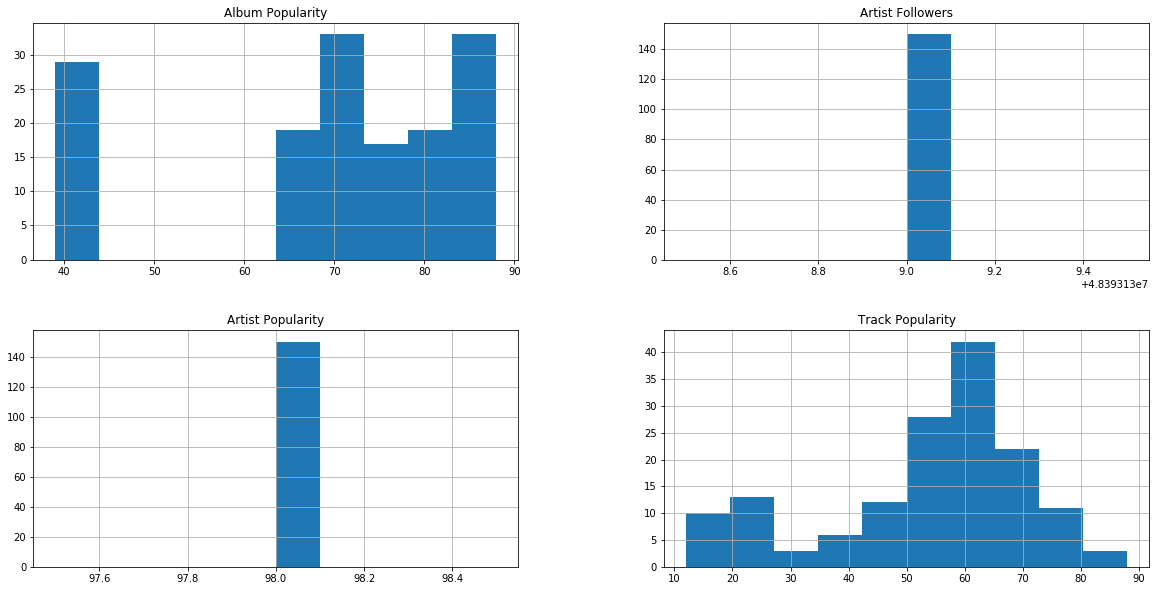

In [33]:
_ = df5.hist(figsize=(20, 10))

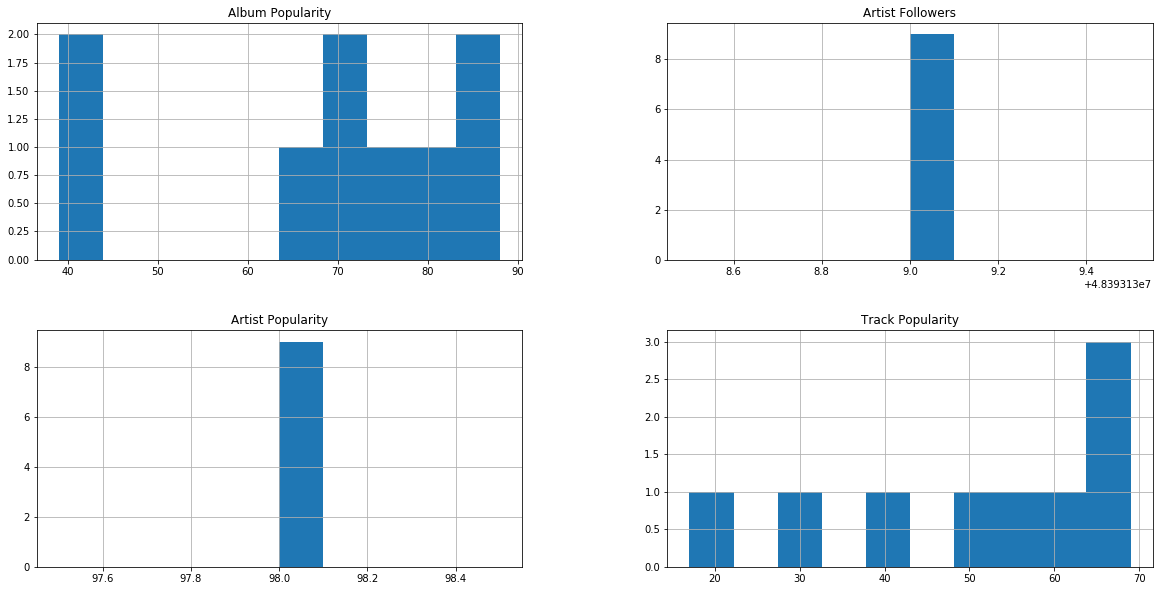

In [35]:
_ = df5[df5['Artist Name']== 'Drake'].drop_duplicates('Album URI').hist(figsize=(20, 10))